In [10]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Apr 11 16:53:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [12]:
# Algorithmic methods imports

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, misc
from PIL import Image
from google.colab.patches import cv2_imshow

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from IPython.display import clear_output 

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
kevin_path = "/content/drive/MyDrive/University Academics/Year 4 EngSci/CSC413 Project/"
jay_path = "./drive/MyDrive/CSC413 Project/"

select_path = kevin_path # Change to kevin_path if needed

#data_path = "./drive/MyDrive/CSC413 Project/trainA"
#label_path = "./drive/MyDrive/CSC413 Project/trainB"
train_path = os.path.join(select_path, "trainA")
train_label_path = os.path.join(select_path, "trainB")
train_path_cropped = os.path.join(select_path, "trainA/original_cropped")
train_label_path_cropped = os.path.join(select_path, "trainB/original_cropped")
test_path = os.path.join(select_path, "testA")
test_label_path = os.path.join(select_path, "testB")
output_path = os.path.join(select_path, "trainA/autoencoder")
test_output_path = os.path.join(select_path, "testA/autoencoder")

# Stacker paths
train_0_cropped = os.path.join(train_path, "original_cropped")
train_1_cropped = os.path.join(train_path, "adaptive_filtered_cropped")
train_2_cropped = os.path.join(train_path, "edge_dilation_erosion_cropped")
train_3_cropped = os.path.join(train_path, "median_filtered_cropped")
train_4_cropped = os.path.join(train_path, "autoencoder") # Already cropped

# Data cleaning and pre-processing
Written by Kevin Zhang 2021-04-08

In [ ]:
if not os.path.exists(train_path+"/original_cropped"):
  os.mkdir(train_path+"/original_cropped")

idx = 0 
for img in sorted(os.listdir(train_path)):
  if img.endswith('.png'):
    input_image_path = os.path.join(train_path,img)
    raw_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    output = raw_image[0:256, 0:256].copy()
 
    idx += 1
    clear_output()
    print("processing", idx)
    cv2.imwrite(os.path.join(train_path+"/original_cropped", img), output)

processing 2448


In [ ]:
if not os.path.exists(train_label_path+"/original_cropped"):
  os.mkdir(train_label_path+"/original_cropped")
 
idx = 0
for img in sorted(os.listdir(train_label_path)):
  if img.endswith('.png'):
    input_image_path = os.path.join(train_label_path,img)
    raw_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    output = raw_image[0:256, 0:256].copy()
 
    idx += 1
    clear_output()
    print("processing", idx)
    cv2.imwrite(os.path.join(train_label_path+"/original_cropped", img), output)

processing 2448


# Defining algorithmic processing methods
Written by Kevin Zhang

In [ ]:
########################################################
# PART 1 - Median Filtering
########################################################
def median_filter(image_path):
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # Load image
  img_median = cv2.medianBlur(img, 25) # Add median filter to image
  result = np.minimum(img.astype(np.uint16)+(255-img_median.astype(np.uint16)), 255)
  return result.astype(np.uint8)

In [ ]:
########################################################
# PART 2 - Edge Detection, Dilation Erosion
########################################################
def edge_dilation_erosion_filter(image_path):
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # Load image
  edges = cv2.Canny(img,100,200)
  dilated = cv2.dilate(edges, np.ones((3,3),np.uint8), iterations=1)
  eroded = cv2.erode(dilated, np.ones((4,4),np.uint8), iterations=1)
  return cv2.bitwise_not(eroded)

In [ ]:
########################################################
# PART 3 - Adaptive Filter
########################################################
def adaptive_filter(image_path):
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # Load image
  return cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,15,20)

## Creating images using algorithmic methods

Written by Kevin Zhang

In [ ]:
if not os.path.exists(train_path+"/median_filtered_cropped"):
  os.mkdir(train_path+"/median_filtered_cropped")
if not os.path.exists(train_path+"/edge_dilation_erosion_cropped"):
  os.mkdir(train_path+"/edge_dilation_erosion_cropped")
if not os.path.exists(train_path+"/adaptive_filtered_cropped"):
  os.mkdir(train_path+"/adaptive_filtered_cropped")

idx = 0 
for img in sorted(os.listdir(train_path_cropped)):
  if img.endswith('.png'):
    input_image_path = os.path.join(train_path_cropped,img)

    median_filter_path = os.path.join(train_path+"/median_filtered_cropped",img)
    edge_dilation_erosion_path = os.path.join(train_path+"/edge_dilation_erosion_cropped",img)
    adaptive_filter_path = os.path.join(train_path+"/adaptive_filtered_cropped",img)

    idx += 1
    clear_output()
    print("processing", idx)

    if not os.path.exists(median_filter_path):
      cv2.imwrite(median_filter_path, median_filter(input_image_path))
    if not os.path.exists(edge_dilation_erosion_path):
      cv2.imwrite(edge_dilation_erosion_path, edge_dilation_erosion_filter(input_image_path))
    if not os.path.exists(adaptive_filter_path):
      cv2.imwrite(adaptive_filter_path, adaptive_filter(input_image_path))

processing 2448


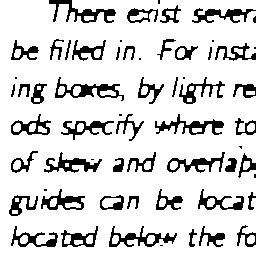

In [ ]:
# Test image
result = edge_dilation_erosion_filter(os.path.join(train_path_cropped, "img_0000.png"))
cv2_imshow(result)

# Machine Learning Methods
Written by Jay Yoo

Adjusted by Kevin Zhang 2021-04-08
- added train-test splits, validation, plot loss

In [ ]:
def prepare_params(batch_size=128, num_epochs=100, learning_rate=1e-4, \
                   summary_epoch_interval=10, validation_split=.15, \
                   shuffle=True, random_seed=0, \
                   loss_function=nn.MSELoss(), optimizer=torch.optim.Adam, \
                   model_save_path="./models"):
  # optimizer is passed the function definition, not a called function 
    # (note the lack of brackets in the base argument)
  
  params = {
      'batch_size' : batch_size,
      'num_epochs' : num_epochs,
      'learning_rate' : learning_rate,
      'summary_epoch_interval' : summary_epoch_interval, 
      'validation_split': validation_split,
      'shuffle': shuffle,
      'random_seed': random_seed,
      'loss_function' : loss_function, 
      'optimizer' : optimizer,
      'save_model_path': model_save_path
  }

  return params

In [ ]:
class model_container():
  def __init__(self, model, params, dataset=None):
    # Model does not have to be transferred to cuda gpu

    self.batch_size = params['batch_size']
    self.num_epochs = params['num_epochs']
    self.learning_rate = params['learning_rate']
    self.summary_epoch_interval = params['summary_epoch_interval']
    self.val_split = params['validation_split']
    self.shuffle = params['shuffle']
    self.random_seed = params['random_seed']
    self.loss_function = params['loss_function']
    self.optimizer = params['optimizer']
    self.save_model_path = params['save_model_path']
    self.model = model.cuda()

    if not os.path.exists(self.save_model_path):
      os.mkdir(self.save_model_path)

    if dataset is not None:
      # code for train-test split on custom dataset
      dataset_size = len(dataset)
      indices = list(range(dataset_size))
      split = int(np.floor(self.val_split * dataset_size))
      if self.shuffle:
        np.random.seed(self.random_seed)
        np.random.shuffle(indices)
      train_indices, val_indices = indices[split:], indices[:split]

      train_sampler = SubsetRandomSampler(train_indices)
      valid_sampler = SubsetRandomSampler(val_indices)

      self.train_loader = DataLoader(dataset, batch_size=self.batch_size, 
                                    sampler=train_sampler, pin_memory=True, num_workers=0)
      self.val_loader = DataLoader(dataset, batch_size=self.batch_size, 
                                          sampler=valid_sampler, pin_memory=True, num_workers=0)
      

  def train(self):
    self.model.train()

    # optimizer = torch.optim.Adam(lr=learning_rate, params=self.model.parameters())
    optimizer = self.optimizer(lr=self.learning_rate, params=self.model.parameters())

    loss_history = []
    val_loss_history = []
    
    for epoch in range(1, self.num_epochs + 1):
      cumulated_loss = 0

      for model_input, labels in self.train_loader:
        model_input = model_input.cuda()
        labels = labels.cuda()
        model_output = self.model(model_input)
        loss = self.loss_function(model_output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cumulated_loss += loss.item()
      
      loss_history.append(cumulated_loss)
      
      self.model.eval()
      cumulated_val_loss = 0
      
      for model_input, labels in self.val_loader:
        model_input = model_input.cuda()
        labels = labels.cuda()
        model_output = self.model(model_input)
        loss = self.loss_function(model_output, labels)
        cumulated_val_loss += loss.item()
    
      val_loss_history.append(cumulated_val_loss)
      
      if cumulated_val_loss <= min(val_loss_history):
        torch.save(self.model.state_dict(), self.save_model_path+"_%d"%epoch)
        print("New model saved!")

      if not epoch % self.summary_epoch_interval:
        print("Epoch %d, Total training loss %0.6f, Total validation loss %0.6f" % (epoch, cumulated_loss, cumulated_val_loss))
        
    plt.figure()
    plt.plot(loss_history, "ro-", label="Train")
    plt.plot(val_loss_history, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")

  def inference(self, data_to_infer, save_path=None, filenames=None, is_autoencoder=True):
    # Assumed to be list of numpy
    # Add option to automatically save to a directory if memory is a concern

    self.model.eval()

    if save_path is None:
      outputs = []
      for data in data_to_infer:
        model_input = torch.from_numpy(data)
        model_input = torch.unsqueeze(model_input, dim=0)
        if is_autoencoder:
          model_input = torch.unsqueeze(model_input, dim=0)
        model_input = model_input.type(torch.FloatTensor)
        model_input = model_input.cuda()
        outputs.append(self.model(model_input).cpu().detach().numpy() * 255)

      return outputs
    else:
      outputs = []
      if not os.path.exists(save_path):
        os.mkdir(save_path)
      if filenames is None:
        filenames = [str(idx)  + '.png' for idx in range(len(data_to_infer))]
      for idx, data in enumerate(data_to_infer):
        model_input = torch.from_numpy(data)
        model_input = torch.unsqueeze(model_input, dim=0)
        if is_autoencoder:
          model_input = torch.unsqueeze(model_input, dim=0)
        model_input = model_input.type(torch.FloatTensor)
        model_input = model_input.cuda()

        model_output = self.model(model_input).cpu().detach().numpy() * 255
        outputs.append(model_output)
        cv2.imwrite(os.path.join(save_path, filenames[idx]), model_output)
      
      return outputs

  def delete_data(self):
    # For memory optimizations
    del self.dataloader
  
  def get_model():
    self.model.eval()
    return self.model

In [ ]:
def get_images_from_dir(data_path, track_progress=True, stop_idx=None, \
                        image_shape=None, cropped=True):

  dir_paths = os.listdir(data_path)
  num_paths = len(dir_paths)

  if stop_idx is None:
    stop_idx = num_paths

  if track_progress == True:
    def show_progress(idx):
      clear_output()
      print(idx, '/', stop_idx)
  else:
    def show_progress(idx):
      pass

  filenames = []
  num_pngs = 0
  image_shape = [np.infty, np.infty]
  for idx, img in enumerate(sorted(dir_paths)):
    if num_pngs == stop_idx:
      break
      
    if img.endswith('.png'):
      num_pngs += 1

  image_shape = [num_pngs] + [256, 256]
  images = np.zeros(image_shape)
    
    
  if not cropped:
    png_idx = 0
    for idx, img in enumerate(sorted(dir_paths)):
      if png_idx == stop_idx:
        break

      show_progress(idx)
      if img.endswith('.png'):
        filenames.append(img)
        image_path = os.path.join(data_path,img)
        raw_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        images[png_idx] = raw_image[0:256, 0:256] / 255
        png_idx += 1
  else:
    png_idx = 0
    for idx, img in enumerate(sorted(dir_paths)):
      if png_idx == stop_idx:
        break

      show_progress(png_idx)
      if img.endswith('.png'):
        filenames.append(img)
        image_path = os.path.join(data_path,img)
        raw_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        images[png_idx] = raw_image/255
        png_idx += 1

  return images, image_shape, filenames

##  Autoencoder model
Written by Jay Yoo

In [ ]:
class autoencoder_dataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        # data and labels are both (dataset size, m, n) where images are m x n

        self.num_data = len(data)
        self.train_data = torch.unsqueeze(torch.from_numpy(data), dim=1)
        self.train_data = self.train_data.type(torch.FloatTensor)
        self.labels = torch.from_numpy(labels)
        self.labels = self.labels.type(torch.FloatTensor)

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        return self.train_data[idx], self.labels[idx]

In [ ]:
def autoencoder_layer(in_channels, out_channels, kernel_size=3, stride=1, \
                  padding=1, bias=True, batchnorm=True, activation='relu', \
                  upsample=None):
    # Convolution layer that maintains shape 
        # with optional activation layer and batchnorm
    # Use stride = 1, kernel = 3, padding = 1 for convenience
    # Activation argument is one of 'relu', 'sigmoid', 'leaky_relu', or 'none

    layers = []

    # Upsampling
    if upsample is not None:
        layers.append(nn.Upsample(scale_factor=upsample))

    # Adding convolutional layer
    layers.append(nn.Conv2d(in_channels=in_channels, \
                            out_channels=out_channels, \
                            kernel_size=kernel_size, \
                            stride=stride, \
                            padding=padding, \
                            bias=bias))

    # Adding batchnorm
    if batchnorm:
        layers.append(nn.BatchNorm2d(out_channels))

    # Adding activation
    if activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'sigmoid':
        layers.append(nn.Sigmoid())
    elif activation == 'leaky_relu':
        layers.append(nn.LeakyReLU())
    elif activation == 'none':
        pass
    else:
        assert False, "Invalid activation function."
        
    return nn.Sequential(*layers)

class autoencoder_architecture(nn.Module):
    def __init__(self, num_hidden_channels=64):
        super().__init__()
        
        self.net = []

        self.net.append(autoencoder_layer(in_channels=1, \
                                      out_channels=num_hidden_channels, \
                                      activation='leaky_relu', \
                                      batchnorm=True, \
                                      upsample=None))
        self.net.append(autoencoder_layer(in_channels=num_hidden_channels, \
                                      out_channels=num_hidden_channels, \
                                      activation='leaky_relu', \
                                      batchnorm=False, \
                                      upsample=None))
        self.net.append(nn.MaxPool2d(2)) # Pool to half of shape
        self.net.append(autoencoder_layer(in_channels=num_hidden_channels, \
                                      out_channels=num_hidden_channels, \
                                      activation='leaky_relu', \
                                      batchnorm=True, \
                                      upsample=None))
        self.net.append(autoencoder_layer(in_channels=num_hidden_channels, \
                                      out_channels=num_hidden_channels, \
                                      activation='leaky_relu', \
                                      batchnorm=False, \
                                      upsample=2))
        self.net.append(autoencoder_layer(in_channels=num_hidden_channels, \
                                      out_channels=1, \
                                      activation='sigmoid', \
                                      batchnorm=False, \
                                      upsample=None))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, concatenated_inputs):
        output = self.net(concatenated_inputs)
        return output.squeeze()

In [ ]:
autoencoder_train_data, shape, train_filenames = get_images_from_dir(train_path_cropped)
autoencoder_labels, shape, _ = get_images_from_dir(train_label_path_cropped)

2447 / 2448


In [ ]:
dataset = autoencoder_dataset(autoencoder_train_data, autoencoder_labels)
autoencoder_model = autoencoder_architecture(num_hidden_channels=64)
autoencoder_params = prepare_params(batch_size=32, summary_epoch_interval=1, num_epochs=100, learning_rate=1e-4, model_save_path="./models/AEmodel")

In [ ]:
autoencoder = model_container(dataset, autoencoder_model, autoencoder_params)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


New model saved!
Epoch 1, Total training loss 3.855344, Total validation loss 0.197453
New model saved!
Epoch 2, Total training loss 0.540544, Total validation loss 0.068965
New model saved!
Epoch 3, Total training loss 0.308325, Total validation loss 0.049062
New model saved!
Epoch 4, Total training loss 0.236588, Total validation loss 0.044046
New model saved!
Epoch 5, Total training loss 0.200335, Total validation loss 0.035327
New model saved!
Epoch 6, Total training loss 0.175782, Total validation loss 0.031652
New model saved!
Epoch 7, Total training loss 0.159258, Total validation loss 0.029086
New model saved!
Epoch 8, Total training loss 0.148118, Total validation loss 0.026903
New model saved!
Epoch 9, Total training loss 0.139351, Total validation loss 0.026215
New model saved!
Epoch 10, Total training loss 0.131151, Total validation loss 0.024236
New model saved!
Epoch 11, Total training loss 0.124214, Total validation loss 0.023629
New model saved!
Epoch 12, Total training

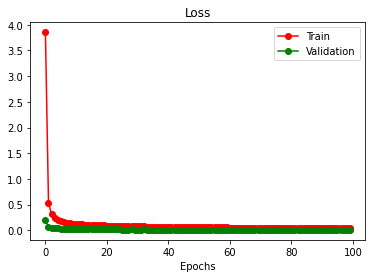

In [ ]:
autoencoder.train()

In [ ]:
# Set MODEL PATH for loading model
PATH = "/content/drive/MyDrive/University Academics/Year 4 EngSci/CSC413 Project/models/AEmodel_100"

model = autoencoder_architecture(num_hidden_channels=64)
model.load_state_dict(torch.load(PATH))
model.eval()

autoencoder = model_container(dataset, model, autoencoder_params)

In [ ]:
autoencoder_test_data, shapes, test_filenames = get_images_from_dir(test_path, cropped=False)
test_outputs = autoencoder.inference(autoencoder_test_data, save_path=test_output_path, filenames=test_filenames)

432 / 433


In [ ]:
cv2_imshow(test_outputs[0])

In [ ]:
# Generating output for saving
outputs = autoencoder.inference(autoencoder_train_data, save_path=output_path, filenames=train_filenames)

## Stacker Model
Written by Jay Yoo

In [ ]:
class stacker_dataset(Dataset):
    def __init__(self, data_to_stack, labels):
        super().__init__()
        # elements of data_to_stack are all (dataset size, m, n) where images are m x n

        self.num_data = len(data_to_stack[0])
        self.train_data = torch.cat([torch.unsqueeze(torch.from_numpy(data), dim=1) for data in data_to_stack], dim=1)
        self.train_data = self.train_data.type(torch.FloatTensor)
            # dataset size x N x m x n where N is the number of inputs to stack
        self.labels = torch.from_numpy(labels)
        self.labels = self.labels.type(torch.FloatTensor)

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        return self.train_data[idx], self.labels[idx]

In [ ]:
def stacker_layer(in_channels, out_channels, kernel_size=3, stride=1, \
                  padding=1, bias=True, batchnorm=True, activation='relu'):
    # Convolution layer that maintains shape 
        # with optional activation layer and batchnorm
    # Use stride = 1, kernel = 3, padding = 1 for convenience
    # Activation argument is one of 'relu', 'sigmoid', or 'none

    layers = []
    # Adding convolutional layer
    layers.append(nn.Conv2d(in_channels=in_channels, \
                            out_channels=out_channels, \
                            kernel_size=kernel_size, \
                            stride=stride, \
                            padding=padding, \
                            bias=bias))

    # Adding batchnorm
    if batchnorm:
        layers.append(nn.BatchNorm2d(out_channels))

    # Adding activation
    if activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'sigmoid':
        layers.append(nn.Sigmoid())
    elif activation == 'none':
        pass
    else:
        assert False, "Invalid activation function."
        
    return nn.Sequential(*layers)

def check_power_2(val):
    # Checks if input val is a power of 2

    return (val & (val - 1) == 0) and val != 0

class stacker_architecture(nn.Module):
    def __init__(self, num_input_types, initial_channels=64, encode_channels=16):
        # initial_channels is the initial channels to convolve to
        # encode channels is the number of channels to decode to

        super().__init__()

        assert check_power_2(initial_channels) and \
        check_power_2(encode_channels), \
        "initial_channels and encode_channels must be powers of 2."

        num_encode_decode_layers = np.log2(initial_channels // encode_channels).astype(int)
        
        self.net = []

        # First layer
        self.net.append(stacker_layer(in_channels=num_input_types, \
                                      out_channels=initial_channels, \
                                      activation='relu', \
                                      batchnorm=True))

        # Encoding
        for layer_idx in range(0, num_encode_decode_layers):
            self.net.append(stacker_layer(in_channels=initial_channels // (2 ** layer_idx), \
                                          out_channels=initial_channels // (2 ** (layer_idx + 1)), \
                                          activation='relu', \
                                          batchnorm=True))
        
        # Decoding
        # Note that no batchnorm in the final decoding layer
        for layer_idx in range(0, num_encode_decode_layers):
            self.net.append(stacker_layer(in_channels=encode_channels * (2 ** layer_idx), \
                                          out_channels=encode_channels * (2 ** (layer_idx + 1)), \
                                          activation='relu', \
                                          batchnorm=layer_idx != num_encode_decode_layers - 1))

        # Final layer
        self.net.append(stacker_layer(in_channels=initial_channels, \
                                      out_channels=1, \
                                      activation='sigmoid', \
                                      batchnorm=False))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, concatenated_inputs):
        output = self.net(concatenated_inputs)
        return output.squeeze()

In [ ]:
from_scratch = True
save_produced_data = False

In [ ]:
if from_scratch:
  num_data = None
  # 2000 is too large
  # 1000 works

  stacker_train_data = []

  train_data_paths = [train_0_cropped, train_1_cropped, train_2_cropped, train_3_cropped, train_4_cropped]

  for data_path in train_data_paths:
    train_data, _, _ = get_images_from_dir(data_path, stop_idx=num_data)
    stacker_train_data.append(np.expand_dims(train_data, axis=0))

  stacker_train_data_np = np.concatenate(stacker_train_data, axis=0)
  del stacker_train_data

  if save_produced_data:
    # Only works for jay_path
    if select_path == jay_path:
      with open(os.path.join(select_path, "stacker_train_data.npy"), 'wb') as f:
          np.save(f, stacker_train_data_np)

  stacker_labels, _, _ = get_images_from_dir(train_label_path_cropped, stop_idx=num_data)

  if save_produced_data:
    # Only works for jay_path
    if select_path == jay_path:
      with open(os.path.join(select_path, "stacker_labels.npy"), 'wb') as f:
          np.save(f, stacker_labels)
else:
  # Only works for jay_path
  if select_path == jay_path:
    stacker_train_data_np = np.load(os.path.join(select_path, "stacker_train_data.npy"))
    # Only works for jay_path
    stacker_labels = np.load(os.path.join(select_path, "stacker_labels.npy"))

338 / 2448


KeyboardInterrupt: ignored

In [ ]:
print(stacker_train_data_np.shape)
print(stacker_labels.shape)

(5, 2448, 256, 256)
(2448, 256, 256)


In [ ]:
dataset = stacker_dataset(stacker_train_data_np, stacker_labels)
stacker_model = stacker_architecture(num_input_types = len(stacker_train_data_np))
stacker_params = prepare_params(batch_size=32, summary_epoch_interval=1, num_epochs=300, learning_rate=1e-4, model_save_path=os.path.join(select_path, "stacker_models", "stacker_model"))

In [ ]:
stacker = model_container(dataset, stacker_model, stacker_params)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


New model saved!
Epoch 1, Total training loss 6.857085, Total validation loss 0.335055
New model saved!
Epoch 2, Total training loss 0.510578, Total validation loss 0.040794
New model saved!
Epoch 3, Total training loss 0.170757, Total validation loss 0.025992
New model saved!
Epoch 4, Total training loss 0.126762, Total validation loss 0.022300
New model saved!
Epoch 5, Total training loss 0.110168, Total validation loss 0.019628
New model saved!
Epoch 6, Total training loss 0.100775, Total validation loss 0.018030
New model saved!
Epoch 7, Total training loss 0.093269, Total validation loss 0.016866
New model saved!
Epoch 8, Total training loss 0.088068, Total validation loss 0.016410
New model saved!
Epoch 9, Total training loss 0.083394, Total validation loss 0.015269
New model saved!
Epoch 10, Total training loss 0.079862, Total validation loss 0.014606
Epoch 11, Total training loss 0.077036, Total validation loss 0.015723
New model saved!
Epoch 12, Total training loss 0.074903, T

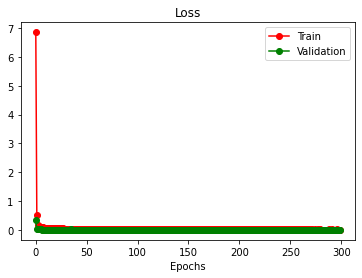

In [ ]:
stacker.train()

In [ ]:
# Set MODEL PATH for loading model
PATH = os.path.join(select_path, "stacker_models_3", "stacker_model_297")
model = stacker_architecture(num_input_types=5)
model.load_state_dict(torch.load(PATH))
model.eval()
stacker_params = prepare_params(batch_size=32, summary_epoch_interval=1, num_epochs=300, learning_rate=1e-4, model_save_path=os.path.join(select_path, "stacker_models", "stacker_model"))

stacker = model_container(model, stacker_params)

In [ ]:
autoencoder_test_data, _, test_filenames = get_images_from_dir(os.path.join(test_path, "autoencoder"), cropped=False)

431 / 432


In [ ]:
print(test_filenames)

['img_0120.png', 'img_0121.png', 'img_0122.png', 'img_0123.png', 'img_0124.png', 'img_0125.png', 'img_0126.png', 'img_0127.png', 'img_0152.png', 'img_0153.png', 'img_0154.png', 'img_0155.png', 'img_0156.png', 'img_0157.png', 'img_0158.png', 'img_0159.png', 'img_0160.png', 'img_0161.png', 'img_0162.png', 'img_0163.png', 'img_0164.png', 'img_0165.png', 'img_0166.png', 'img_0167.png', 'img_0256.png', 'img_0257.png', 'img_0258.png', 'img_0259.png', 'img_0260.png', 'img_0261.png', 'img_0262.png', 'img_0263.png', 'img_0264.png', 'img_0265.png', 'img_0266.png', 'img_0267.png', 'img_0268.png', 'img_0269.png', 'img_0270.png', 'img_0271.png', 'img_0272.png', 'img_0273.png', 'img_0274.png', 'img_0275.png', 'img_0276.png', 'img_0277.png', 'img_0278.png', 'img_0279.png', 'img_0328.png', 'img_0329.png', 'img_0330.png', 'img_0331.png', 'img_0332.png', 'img_0333.png', 'img_0334.png', 'img_0335.png', 'img_0384.png', 'img_0385.png', 'img_0386.png', 'img_0387.png', 'img_0388.png', 'img_0389.png', 'img_03

In [ ]:
# raw_test_data, _, test_filenames = get_images_from_dir(test_path, cropped=False)
median_filtering_test_data = []
edge_dilation_erosion_filtering_test_data = []
adaptive_filtering_test_data = []
raw_test_data_paths = [os.path.join(test_path, path) for path in test_filenames]

original_test_data, _, _ = get_images_from_dir(test_path, cropped=False)
original_test_data = np.expand_dims(original_test_data, axis=0)

for data_path in raw_test_data_paths:
  median_filtering_test_data.append(np.expand_dims(median_filter(data_path)[0:256, 0:256] / 255, 0))
  edge_dilation_erosion_filtering_test_data.append(np.expand_dims(edge_dilation_erosion_filter(data_path)[0:256, 0:256] / 255, 0))
  adaptive_filtering_test_data.append(np.expand_dims(adaptive_filter(data_path)[0:256, 0:256] / 255, 0))

original_test_data = np.concatenate(original_test_data, axis=0)
median_filtering_test_data = np.concatenate(median_filtering_test_data, axis=0)
edge_dilation_erosion_filtering_test_data = np.concatenate(edge_dilation_erosion_filtering_test_data, axis=0)
adaptive_filtering_test_data = np.concatenate(adaptive_filtering_test_data, axis=0)

In [ ]:
raw_stacker_test_data = [original_test_data, adaptive_filtering_test_data, edge_dilation_erosion_filtering_test_data, median_filtering_test_data, autoencoder_test_data]
# Order is adaptive filtering, edge dilation, median, autoencoder

stacker_test_data = np.concatenate([np.expand_dims(data, axis=1) for data in raw_stacker_test_data], axis=1)

In [ ]:
print(stacker_test_data.shape)

(432, 5, 256, 256)


In [ ]:
test_outputs = stacker.inference(stacker_test_data, save_path=os.path.join(select_path, "stacker_test_outputs"), filenames=test_filenames, is_autoencoder=False)

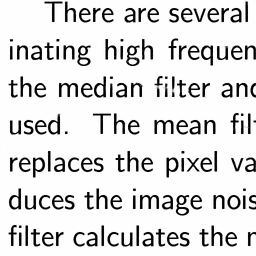

In [ ]:
# This is the output of training stacker for 300 epochs
cv2_imshow(test_outputs[0])

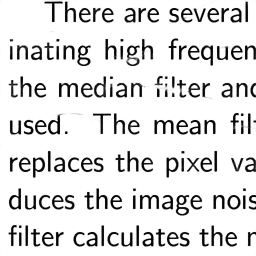

In [ ]:
cv2_imshow(autoencoder_test_data[0] * 255)

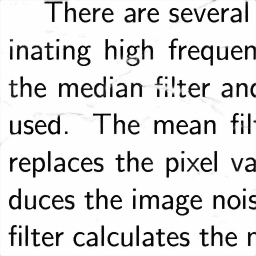

In [ ]:
# This is the output of training stacker for 100 epochs, note that it's worse than the autencoder output by a very slight amount
cv2_imshow(test_outputs[0])

In [ ]:
# Generating output for saving
test_outputs = stacker.inference(stacker_test_data, save_path=os.path.join(select_path, "stacker_outputs"), filenames=test_filenames)

## Full inference
Written by Jay Yoo

In [ ]:
def get_images_from_dir_uncropped(data_path, track_progress=True, stop_idx=None, \
                        image_shape=None):

  dir_paths = os.listdir(data_path)
  num_paths = len(dir_paths)

  if stop_idx is None:
    stop_idx = num_paths

  if track_progress == True:
    def show_progress(idx):
      clear_output()
      print(idx, '/', stop_idx)
  else:
    def show_progress(idx):
      pass

  filenames = []
  images = []

  png_idx = 0
  for idx, img in enumerate(sorted(dir_paths)):
    if png_idx == stop_idx:
      break

    show_progress(png_idx)
    if img.endswith('.png'):
      filenames.append(img)
      image_path = os.path.join(data_path,img)
      raw_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
      images.append(raw_image/255)
      png_idx += 1

  return images, image_shape, filenames

In [ ]:
# raw_test_data, _, test_filenames = get_images_from_dir(test_path, cropped=False)
median_filtering_test_data = []
edge_dilation_erosion_filtering_test_data = []
adaptive_filtering_test_data = []

original_test_data, _, test_filenames = get_images_from_dir_uncropped(test_path)
raw_test_data_paths = [os.path.join(test_path, path) for path in test_filenames]

for data_path in raw_test_data_paths:
  median_filtering_test_data.append(median_filter(data_path) / 255)
  edge_dilation_erosion_filtering_test_data.append(edge_dilation_erosion_filter(data_path) / 255)
  adaptive_filtering_test_data.append(adaptive_filter(data_path) / 255)

431 / 433


In [ ]:
inference_shape = (256, 256)

In [ ]:
processed_data_to_infer_all = []
# for test_data in [original_test_data, adaptive_filtering_test_data, edge_dilation_erosion_filtering_test_data, median_filtering_test_data, autoencoder_test_data]:
for test_data in [original_test_data, adaptive_filtering_test_data, edge_dilation_erosion_filtering_test_data, median_filtering_test_data]:
  # Create patched data
  processed_data_to_infer = []
  
  for data_idx in range(len(test_data)):
    test_data_y = test_data[data_idx].shape[0]
    test_data_x = test_data[data_idx].shape[1]

    y_starts = []
    x_starts = []

    y_start = 0
    if test_data_y == inference_shape[0]:
      y_starts.append(0)
    else:
      while y_start + inference_shape[0] < test_data_y:
        y_starts.append(y_start)
        y_start += inference_shape[0]

      if test_data_y % inference_shape[0] != 0:
        y_starts.append(test_data_y - inference_shape[0])

    if test_data_x == inference_shape[1]:
      x_starts.append(0)
    else:
      x_start = 0
      while x_start + inference_shape[1] < test_data_x:
        x_starts.append(x_start)
        x_start += inference_shape[1]

      if test_data_x % inference_shape[1] != 0:
        x_starts.append(test_data_x - inference_shape[1])

    for y_start in y_starts:
      for x_start in x_starts:
        patch = test_data[data_idx][y_start:y_start + inference_shape[0], x_start:x_start + inference_shape[1]]
        processed_data_to_infer.append((data_idx, y_start, x_start, patch))
  processed_data_to_infer_all.append(processed_data_to_infer)

In [ ]:
# Autoencoder inference
# Set MODEL PATH for loading model
PATH = select_path + "models/AEmodel_100"

model = autoencoder_architecture(num_hidden_channels=64)
model.load_state_dict(torch.load(PATH))
model.eval()
autoencoder_params = prepare_params(batch_size=32, summary_epoch_interval=1, num_epochs=100, learning_rate=1e-4, model_save_path=select_path)

autoencoder = model_container(model, autoencoder_params)
test_autoencoder_data_out = autoencoder.inference(np.array([_[3] for _ in processed_data_to_infer_all[0]]))

In [ ]:
autoencoder_test_data = []
for idx in range(len(test_autoencoder_data_out)):
  shape_data = processed_data_to_infer_all[0][idx][:3]
  autoencoder_test_data.append((shape_data[0], shape_data[1], shape_data[2], test_autoencoder_data_out[idx] / 255))

In [ ]:
# Generating uncropped autoencoder outputs
original_test_data, _, _ = get_images_from_dir_cropped(test_path)

inferred_data = []
divisor_array = []
for data in original_test_data:
  inferred_data.append(np.zeros_like(data).astype(np.float32))
  divisor_array.append(np.zeros_like(data).astype(np.float32))
del original_test_data

# Patching outputs back together
# inferred_outputs assumed to be in same order as processed_data_to_infer
for idx in range(len(autoencoder_test_data)):
  image_idx, y_start, x_start = processed_data_to_infer[idx][:3]
  
  inferred_data[image_idx][y_start:y_start + inference_shape[0], x_start:x_start + inference_shape[1]] += autoencoder_test_data[idx][3] * 255
  divisor_array[image_idx][y_start:y_start + inference_shape[0], x_start:x_start + inference_shape[1]] += 1

# inferred_data = inferred_data / divisor_array

431 / 433


In [ ]:
for idx in range(len(inferred_data)):
  inferred_data[idx] /= divisor_array[idx]

(420, 540)


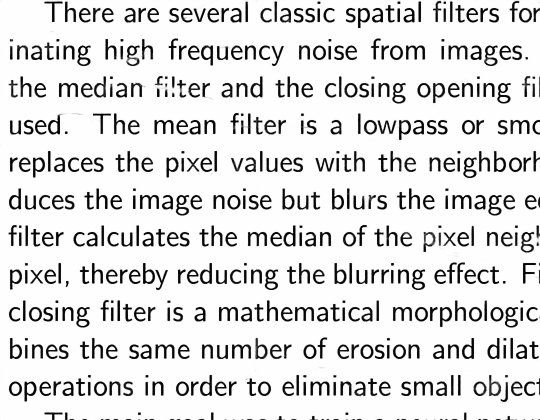

In [ ]:
print(inferred_data[0].shape)
cv2_imshow(inferred_data[0])

In [ ]:
for idx in range(len(inferred_data)):
  cv2.imwrite(os.path.join(select_path, "autoencoder_test_outputs_full", "autoencoder_cleaned_" + test_filenames[idx]), inferred_data[idx])

In [ ]:
len(processed_data_to_infer_all)

In [ ]:
processed_data_to_infer_all.append(test_autoencoder_data)

In [ ]:
print(processed_data_to_infer_all[0][50][3].shape)
# type, patch_idx, tuple of details

(256, 256)


In [ ]:
for test_data in [original_test_data, adaptive_filtering_test_data, edge_dilation_erosion_filtering_test_data, median_filtering_test_data, autoencoder_test_data]:
  del test_data

In [ ]:
print(processed_data_to_infer_all[0][50][3].shape)
# type, patch_idx, tuple of details

(256, 256)


In [ ]:
test_dataset = []
for idx in range(len(processed_data_to_infer_all)):
  curr_data = np.array([_[3] for _ in processed_data_to_infer_all[idx]])
  test_dataset.append(curr_data)

# self.train_data = torch.cat([torch.unsqueeze(torch.from_numpy(data), dim=1) for data in data_to_stack], dim=1)

In [ ]:
print(len(test_dataset))

5


In [ ]:
print(test_dataset[3].shape)

(2592, 256, 256)


In [ ]:
test_dataset = [np.expand_dims(data, axis=1) for data in test_dataset]

In [ ]:
test_dataset = np.concatenate(test_dataset, axis=1)

In [ ]:
# Set MODEL PATH for loading model
PATH = os.path.join(select_path, "stacker_models_3", "stacker_model_297")
model = stacker_architecture(num_input_types=5)
model.load_state_dict(torch.load(PATH))
model.eval()
stacker_params = prepare_params(batch_size=32, summary_epoch_interval=1, num_epochs=300, learning_rate=1e-4, model_save_path=select_path)

stacker = model_container(model, stacker_params)

In [ ]:
test_outputs = stacker.inference(test_dataset.astype(np.float32), is_autoencoder=False)

In [ ]:
print(test_outputs[0].dtype)
print(test_dataset.dtype)

float32
float64


In [ ]:
original_test_data, _, _ = get_images_from_dir_cropped(test_path)

431 / 433


In [ ]:
inferred_data = []
divisor_array = []
for data in original_test_data:
  inferred_data.append(np.zeros_like(data).astype(np.float64))
  divisor_array.append(np.zeros_like(data).astype(np.float64))
del original_test_data

In [ ]:
# Patching outputs back together
# inferred_outputs assumed to be in same order as processed_data_to_infer
for idx in range(len(test_outputs)):
  image_idx, y_start, x_start = processed_data_to_infer[idx][:3]
  inferred_data[image_idx][y_start:y_start + inference_shape[0], x_start:x_start + inference_shape[1]] += test_outputs[idx]
  divisor_array[image_idx][y_start:y_start + inference_shape[0], x_start:x_start + inference_shape[1]] += 1

# inferred_data = inferred_data / divisor_array

In [ ]:
for idx in range(len(inferred_data)):
  inferred_data[idx] /= divisor_array[idx]

(420, 540)


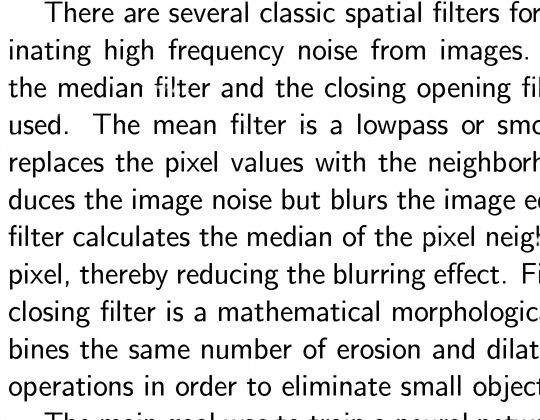

In [ ]:
print(inferred_data[0].shape)
cv2_imshow(inferred_data[0])

In [ ]:
for idx in range(len(inferred_data)):
  cv2.imwrite(os.path.join(select_path, "stacker_test_outputs_full", "stacker_cleaned_" + test_filenames[idx]), inferred_data[idx])

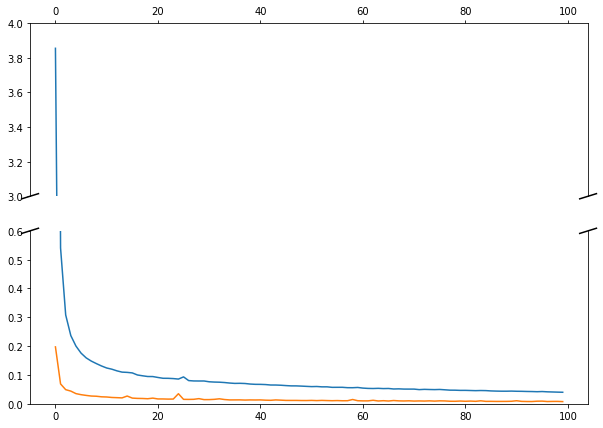

In [42]:
loss_txt = open(os.path.join(select_path, 'autoencoder_losses.txt'), 'r')
Lines = loss_txt.readlines()

train_losses = []
val_losses = []
for line in Lines:
  if line.startswith("Epoch"):
    line = line.replace(",", '')
    tokens = line.split()
    train_losses.append(float(tokens[5]))
    val_losses.append(float(tokens[9]))

f, (ax, ax2) = plt.subplots(2, 1, sharex=True)
f.set_size_inches(10, 7)
ax.plot(train_losses)
ax.plot(val_losses)
ax2.plot(train_losses)
ax2.plot(val_losses)
ax.set_ylim(3., 4.)  # outliers only
ax2.set_ylim(0, .6)  # most of the data

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

d = .015  
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)   
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  

kwargs.update(transform=ax2.transAxes)  
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  

plt.show()

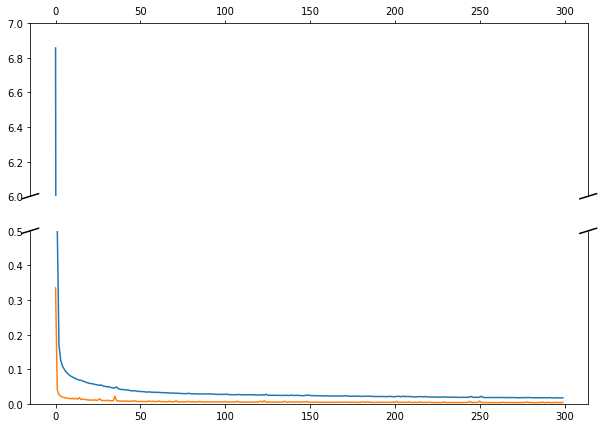

In [44]:
loss_txt = open(os.path.join(select_path, 'stacker_losses.txt'), 'r')
Lines = loss_txt.readlines()

train_losses = []
val_losses = []
for line in Lines:
  if line.startswith("Epoch"):
    line = line.replace(",", '')
    tokens = line.split()
    train_losses.append(float(tokens[5]))
    val_losses.append(float(tokens[9]))

f, (ax, ax2) = plt.subplots(2, 1, sharex=True)
f.set_size_inches(10, 7)
ax.plot(train_losses)
ax.plot(val_losses)
ax2.plot(train_losses)
ax2.plot(val_losses)
ax.set_ylim(6., 7.)  # outliers only
ax2.set_ylim(0, .5)  # most of the data

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

d = .015  
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)   
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  

kwargs.update(transform=ax2.transAxes)  
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  

plt.show()
    